# Jacob's notebook wuup

In [1]:
from matplotlib import pyplot as plt
import numpy as np

## Pixel intensity distribution

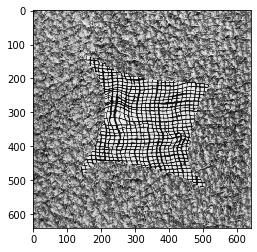

In [2]:
#fname = "data/simple_test.png"
fname = "data/overlap_test.png"
img = plt.imread(fname)
plt.imshow(img, cmap='gray')

In [3]:
def init_circle_curve(n_points, center, radius):
    th = np.arange(0,1,1/n_points)*(2*np.pi)
    snake = np.array([np.cos(th), np.sin(th)]).transpose()*radius + center
    return snake

def plot_snake(snake,col='blue'):
    plt.plot(*zip(*np.flip(snake,axis=1)),'.-',linewidth=1,color=col)
    
def plot_forces(snake, forces, factor):
    for i in range(len(snake)):
        d = forces[i,:]*factor
        plt.arrow(snake[i,1],snake[i,0],d[1],d[0], color='green')

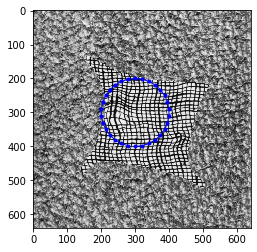

In [4]:
snake = init_circle_curve(30,(300,300),100)
plt.imshow(img, cmap='gray')
plot_snake(snake)

Find mask that describes the inner part of the snake:

In [5]:
def curve_normals(snake):
    a = np.zeros_like(snake)
    s_prev = np.roll(snake,  1, axis=0) # prev
    s_next = np.roll(snake, -1, axis=0) # next
    a[:,0] =   s_next[:,1] - s_prev[:,1]
    a[:,1] = -(s_next[:,0] - s_prev[:,0])
    a = a / np.linalg.norm(a, axis=1)[:,None]
    return a

In [6]:
from collections import deque

def pixels_between_points(p1, p2):
    vec = p2-p1
    l = np.linalg.norm(vec)
    p = np.arange(l)/l
    return (p1+p[:,None]*vec).astype(int)

def curve_contour(snake, mask_shape):
    mask = np.zeros(mask_shape).astype(bool)
    p = snake[-1,]
    for i in range(len(snake)):
        idx = pixels_between_points(p, snake[i,])
        p = snake[i,]
        mask[idx[:,0],idx[:,1]] = True
    return mask

def fill_contour(mask, seed):
    queue = deque([seed])
    while(queue):
        pt = queue.popleft()
        if(mask[pt[0],pt[1]] != True):
            mask[pt[0],pt[1]] = True
            # add neighbours to queue
            queue.append( (pt[0] - 1, pt[1]) )
            queue.append( (pt[0] + 1, pt[1]) )
            queue.append( (pt[0], pt[1] - 1) )
            queue.append( (pt[0], pt[1] + 1) )           
        
def snake_enclosed(snake, normals, img_shape):
    mask = curve_contour(snake, img_shape)
    p0 = tuple((snake[0,]-2*normals[0,]).astype(int))
    fill_contour(mask,p0)
    return mask.astype(bool)

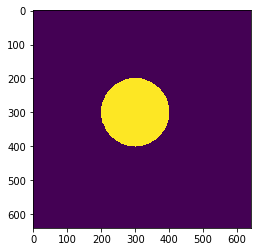

In [7]:
normals = curve_normals(snake)
mask = snake_enclosed(snake, normals, img.shape)
plt.imshow(mask)

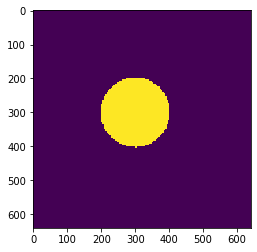

In [8]:
from skimage.transform import resize
mask = snake_enclosed(snake/4, normals, (int(img.shape[0]/4), int(img.shape[1]/4)))
mask = resize(mask, img.shape, order = 0, preserve_range=True).astype(bool)
plt.imshow(mask)

Find which pixels intensities are found inside and outside the snake

In [9]:
all_unique = np.unique(img.flatten()) # array containing each different pixel value

count_inside = np.zeros_like(all_unique)
count_outside = np.zeros_like(all_unique)
count_total = np.zeros_like(all_unique)
for i,x in enumerate(all_unique):
    count_inside[i] = (img[mask]==x).sum()
    count_outside[i] = (img[~mask]==x).sum()
    count_total[i] = count_inside[i]+count_outside[i];

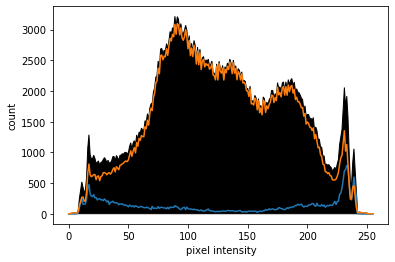

In [10]:
plt.fill(count_total, color='black')
plt.plot(count_inside)
plt.plot(count_outside)
plt.xlabel('pixel intensity')
plt.ylabel('count')
plt.show()

Scale according to inside/outside area

In [11]:
total_inside = mask.sum()
total_outside = img.size - total_inside
pixel_prc_in = count_inside/total_inside
pixel_prc_out = count_outside/total_outside

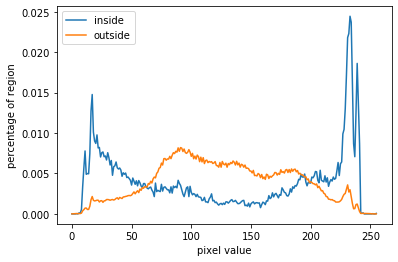

In [12]:
plt.plot(pixel_prc_in)
plt.plot(pixel_prc_out)
plt.xlabel('pixel value')
plt.ylabel('percentage of region')
plt.legend(['inside','outside'])
plt.show()

Calculate probalility of being inside contour based on pixel intensity

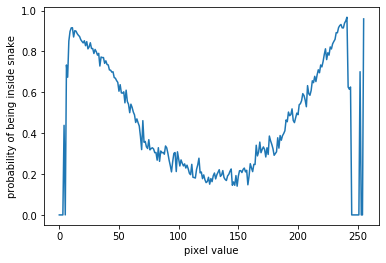

In [13]:
pixel_probs = pixel_prc_in / (pixel_prc_in+pixel_prc_out)
plt.plot(pixel_probs)
plt.xlabel('pixel value')
plt.ylabel('probability of being inside snake')
plt.show()

Plot as probability image

In [14]:
prob_img = np.zeros_like(img)
for i,x in enumerate(all_unique):
    prob_img[img==x] = pixel_probs[i]

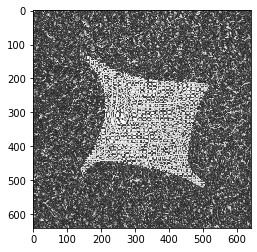

In [15]:
plt.imshow(prob_img, cmap='gray')

Reduce noie by snoothing

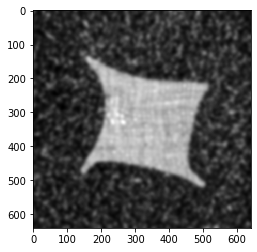

In [16]:
import scipy.ndimage as ndimage
prob_img_smooth = ndimage.gaussian_filter(prob_img, sigma=(5, 5), order=0)

# TODO Normalize ?

plt.imshow(prob_img_smooth, cmap='gray')

## Deform model on smoothed prob image

#### Wrap code in methods

In [17]:
from collections import deque
import snake_functions as sf
#import importlib
#importlib.reload(sf)

class deform_model():
    def __init__(self,n_points, center, radius, smooth_param):
        th = np.arange(0,1,1/n_points)*(2*np.pi)
        self.snake = np.array([np.cos(th), np.sin(th)]).transpose()*radius + center
        self.normals = self.compute_normals()
        self.smooth_mat = sf.smooth_matrix(n_points, smooth_param[0], smooth_param[1])

    def compute_normals(self):
        a = np.zeros_like(self.snake)
        s_prev = np.roll(self.snake,  1, axis=0) # prev
        s_next = np.roll(self.snake, -1, axis=0) # next
        a[:,0] =   s_next[:,1] - s_prev[:,1]
        a[:,1] = -(s_next[:,0] - s_prev[:,0])
        a = a / np.linalg.norm(a, axis=1)[:,None]
        return a
    
    def read_values(self,img):
        idx_xy = self.snake.astype(int)
        return (img[idx_xy[:,0], idx_xy[:,1]])

    def set_forces(self, forces):
        self.force_vecs = forces[:,None] * self.normals
        
    def update(self, step_size):
        self.snake += self.force_vecs*step_size
        self.regularize()
        self.normals = self.compute_normals()
        
    def regularize(self):
        self.snake[:,:] = self.smooth_mat.dot(self.snake)
        snakeT = sf.distribute_points(self.snake.T)
        snakeT = sf.remove_intersections(snakeT)
        self.snake[:,:] = snakeT.T
    '''
    def enclosed_mask(self, img_shape, down_samp = 1):
        if(down_samp>1):
            mask_shape = tuple(np.divide(img_shape, down_samp).astype(int))
            snake = self.snake/4
        else:
            mask_shape = img_shape
            snake = self.snake

        mask = curve_contour(snake, mask_shape)
        p0 = tuple((snake[0,]-2*self.normals[0,]).astype(int))
        fill_contour(mask,p0)
        
        if(down_samp>1):
            mask = resize(mask, img_shape, order = 0, preserve_range=True)
            
        return mask.astype(bool)
    '''
    
    def enclosed_mask(self, img_shape, down_samp = 1):
        '''
        Creates a (down sampled) region of interest around the snake, 
        marks all pixels under the contour and flood fills its surrondings.
        The mask is then upsampled and padded to match the full scale image.
        '''
        snake = self.snake / down_samp

        # Find rectangle around contour
        r_min = snake[:,0].min().astype(int)
        c_min = snake[:,1].min().astype(int)
        r_max = snake[:,0].max().astype(int)
        c_max = snake[:,1].max().astype(int)

        rows = r_max-r_min
        cols = c_max-c_min

        pad = 3
        mask = np.ones((rows+2*pad, cols+2*pad), dtype=bool) # create region of interest with some padding
        mask[:,[0,-1]] = mask[[0,-1]] = False # set edges to True to create boundary

        snake = snake - [r_min,c_min] + pad
        p = snake[-1,]
        for i in range(len(snake)):
            idx = sf.pixels_between_points(p, snake[i,])
            p = snake[i,]
            mask[idx[:,0],idx[:,1]] = False

        sf.fill_contour(mask,[1,1],value=False)
        mask = mask[pad:-pad, pad:-pad] # remove padding
        if(down_samp>1):
            mask = resize(mask, (down_samp*rows, down_samp*cols), order = 0, preserve_range=True)

        full_mask = np.zeros((img_shape), dtype=bool)
        full_mask[down_samp*r_min:down_samp*r_max, down_samp*c_min:down_samp*c_max] = mask.astype(bool)
        return full_mask


In [18]:
def create_prob_image(img, mask):    
    all_unique = np.unique(img.flatten()) # array containing each different pixel value

    count_inside = np.zeros_like(all_unique)
    count_outside = np.zeros_like(all_unique)
    count_total = np.zeros_like(all_unique)
    for i,x in enumerate(all_unique):
        count_inside[i] = (img[mask]==x).sum()
        count_outside[i] = (img[~mask]==x).sum()
        count_total[i] = count_inside[i]+count_outside[i]
        
    total_inside = mask.sum()
    total_outside = img.size - total_inside
    pixel_prc_in = count_inside/total_inside
    pixel_prc_out = count_outside/total_outside
    
    pixel_probs = pixel_prc_in / (pixel_prc_in+pixel_prc_out)
    
    prob_img = np.zeros_like(img, dtype=float)
    for i,x in enumerate(all_unique):
        prob_img[img==x] = pixel_probs[i]
    prob_img = ndimage.gaussian_filter(prob_img, sigma=(5, 5), order=0)
    return prob_img


#### Open cv draw methods

In [19]:
import cv2

def draw_snake(img_out, snake, color=(255,0,0)):
    snake = np.flip(snake,axis=1)
    pt0 = snake[-1,:].astype(int)
    for i in range(len(snake)):
        pt1 = snake[i,:].astype(int)
        img_out = cv2.line(img_out, tuple(pt0), tuple(pt1), color, 1)
        img_out = cv2.circle(img_out, tuple(pt1), 2, color, cv2.FILLED, 1)
        pt0 = pt1
    return img_out 

def draw_forces(img_out, snake, forces, color=(255,0,0)):
    snake = np.flip(snake,axis=1)
    forces = np.flip(forces,axis=1)
    for i in range(len(snake)):
        pt = snake[i,:]
        pt2 = snake[i,:] + forces[i,]
        img_out = cv2.arrowedLine(img_out, tuple(pt.astype(int)), tuple(pt2.astype(int)), color, 1)
    return img_out 

def vis_snake(img, snake, forces={}, wait=30, color=(255,0,0), title="snake"):
    img_out = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    img_out = draw_snake(img_out, snake, color)
    if len(forces)>0:
        img_out = draw_forces(img_out, snake, forces, color=color)
    cv2.imshow(title, img_out)
    key = cv2.waitKey(wait)
    return key==27


#### Run

In [20]:
model = deform_model(n_points = 140, center = (200,300), radius = 100, smooth_param=(0.2,0.2))

step_size = 100

i = 0
while(True):
    if(i%5==0):
        mask = model.enclosed_mask(img.shape, down_samp=4)
        prob_img = create_prob_image(img, mask)
    model.set_forces(model.read_values(prob_img) - 0.5)
    
    # Visualize
    cv2.imshow("mask", mask.astype(float))
    vis_snake(img, model.snake, wait=1, title="Original")
    if vis_snake(prob_img.astype('float32'), model.snake, 200*model.force_vecs, wait=30, title="Probability"):
        break
    
    model.update(step_size)
    i+=1
    
cv2.destroyAllWindows()
cv2.waitKey(1);

# Creating patch dictionary

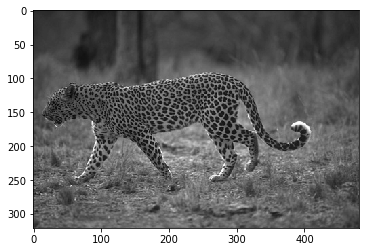

In [21]:
fname = "data/134052.jpg"
img = cv2.imread(fname, cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')

In [22]:
# returns flattened image patches from image A of shape BSZ
def im2col(A, BSZ, stepsize=1):
    # Parameters
    m,n = A.shape
    s0, s1 = A.strides
    nrows = m-BSZ[0]+1
    ncols = n-BSZ[1]+1
    shp = BSZ[0],BSZ[1],nrows,ncols
    strd = s0,s1,s0,s1

    out_view = np.lib.stride_tricks.as_strided(A, shape=shp, strides=strd)
    return out_view.reshape(BSZ[0]*BSZ[1],-1)[:,::stepsize]

Collapse image patches into vector features

In [23]:
E = 2
K = 1+2*E
patch_size = (K,K)
features = im2col(img, patch_size).transpose()
new_shape = tuple(np.array(img.shape) - (2*E))
print(features.shape)

(151209, 25)


Divide features into clusters (using just a sample to speed up the process)

In [24]:
import sklearn.cluster

samp_size = 10000
clusters = 100
sample_idx = np.random.permutation(features.shape[0])[:samp_size]
feature_sample = features[sample_idx,:]
kmeans = sklearn.cluster.KMeans(n_clusters=clusters, verbose=False).fit(feature_sample)

In [25]:
predicted_clusters = kmeans.predict(features)

In [26]:
cluster_img = predicted_clusters.reshape(img.shape[0]-2*E, img.shape[1]-2*E)

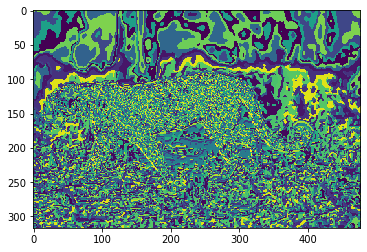

In [27]:
plt.imshow(cluster_img)

Since the clusters have random colors there's not a lot to see

__Create probability image from the cluster distribution, just as with the pixel intensities__

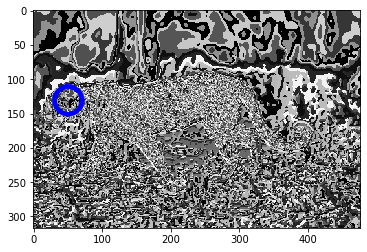

In [28]:
#model = deform_model(n_points = 140, center = (150,200), radius = 40, smooth_param=(0.05,0.1))
model = deform_model(n_points = 140, center = (130,50), radius = 20, smooth_param=(0.05,0.1))

plt.imshow(cluster_img, cmap='gray')
plot_snake(model.snake)

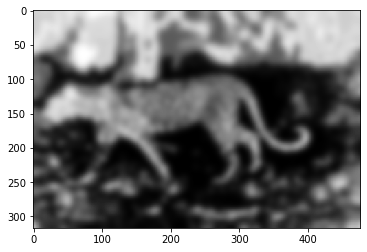

In [29]:
mask = model.enclosed_mask(cluster_img.shape, down_samp=4)
prob_img = create_prob_image(cluster_img,mask)
plt.imshow(prob_img, cmap='gray')

#### Run again!

In [30]:
step_size = 20

i = 0
while(True):
    if(i%5==0):
        mask = model.enclosed_mask(cluster_img.shape, down_samp=4)
        prob_img = create_prob_image(cluster_img, mask)
    model.set_forces(model.read_values(prob_img) - 0.5)
    
    # Visualize
    cv2.imshow("mask", mask.astype(float))
    vis_snake(img, model.snake, wait=1, title="Original")
    if vis_snake(prob_img.astype('float32'), model.snake, 200*model.force_vecs, wait=30, title="Probability"):
        break
    
    model.update(step_size)
    i+=1
    
cv2.destroyAllWindows()
cv2.waitKey(1);